In [25]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2

import torch

In [6]:
DATA_ROOT = 'data/Cityscapes'


(1024, 2048, 1)
(1024, 2048, 3)


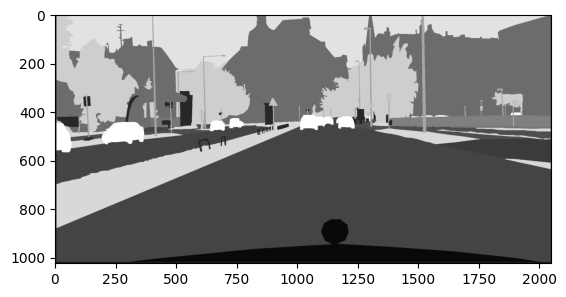

In [32]:
mask = plt.imread(DATA_ROOT + '/labels/aachen_000001_000019_gtFine_labelIds.png')
mask = np.expand_dims(mask, axis=2)
print(mask.shape)
plt.imshow(mask[..., 0], cmap='gray');

img = plt.imread(DATA_ROOT + '/images/aachen_000001_000019_leftImg8bit.png')
print(img.shape)
#plt.imshow(img[..., 0], cmap='gray');


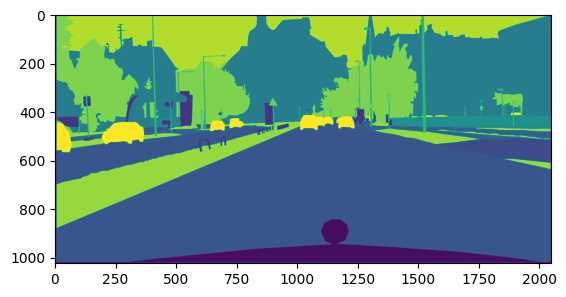

In [42]:
mask = plt.imread(DATA_ROOT + '/labels/aachen_000001_000019_gtFine_labelIds.png')*255
mask = np.expand_dims(mask, axis=2)
plt.imshow(mask[..., 0]);



In [34]:
np.unique(mask * 255)


array([ 0.,  1.,  3.,  4.,  5.,  6.,  7.,  8., 11., 12., 13., 17., 19.,
       20., 21., 22., 23., 26.], dtype=float32)

In [40]:
labels =[
    "road",
    "sidewalk",
    "building",
    "wall",
    "fence",
    "pole",
    "light",
    "sign",
    "vegetation",
    "terrain",
    "sky",
    "person",
    "rider",
    "car",
    "truck",
    "bus",
    "train",
    "motocycle",
    "bicycle"]

print(len(labels))

19


In [37]:
for i in range(19):
    mask = plt.imread(DATA_ROOT + '/labels/aachen_000001_000019_gtFine_labelIds.png')
    mask = np.where(mask == i, 255, 0)
    mask = mask[:,:,0]
    print(np.unique(mask))
    plt.title(f'class: {i} {labels[i]}')
    plt.imshow(mask)
    plt.show()

AttributeError: 'list' object has no attribute 'size'